Dana Rozenblum & Efrat Magidov

In the main notebook we implemtnted the text classifier network with an embedded layer. However, at start we thought that the intention was to include the word2vec vectors of each word for each song as part of the input instead.

We include here this type of solution. The size of the input led to crushes of the notebooks so here we didn't continue to finalize the solution (like the rare words removal from the input we performed in the main notebook), improve the network (the results of the implenetation in the main notebook are better) or try the extra modifications.

In [61]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import torch
from tqdm import tqdm
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import time
import copy
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_parquet("https://raw.githubusercontent.com/omriallouche/ydata_deep_learning_2021/master/data/metrolyrics.parquet")

# lower_case
df['lyrics_lower'] = df['lyrics'].apply(lambda x: x.lower())

# remove punctuation
df['lyrics_no_punct'] = df['lyrics_lower'].str.replace('[^\w\s]','')

# remove new lines
df['lyrics_no_punct_no_n'] = df['lyrics_no_punct'].replace(r'\n',' ', regex=True) 

# tokenization
df['tokenized_clean_lyrics'] = df['lyrics_no_punct_no_n'].apply(lambda x: nltk.word_tokenize(x))

# remove stop words
stop = stopwords.words('english')
df['tokenized_clean_lyrics'] = df['tokenized_clean_lyrics'].apply(lambda x: [item for item in x if item not in stop])

df['clean_lyrics'] = df['tokenized_clean_lyrics'].apply(lambda x: " ".join(x) )

In [10]:
sent_corpus = df['tokenized_clean_lyrics']

w2v_model_context5 = Word2Vec(sentences=sent_corpus, size=300, min_count=20, workers=4, window=5)

model = w2v_model_context5

In [4]:
def get_song_vec_mat(tokenized_lyrics):
    songs_embeddings = torch.zeros((df.shape[0], 300, 128))
    for song_ind, song in tqdm(enumerate(tokenized_lyrics), position=0, leave=True):
        words_list = list(set(song))[:128]
        word_vecs= np.zeros((300,128))
        for word_ind, word in enumerate(words_list):
            if word in model.wv.vocab:
                songs_embeddings[song_ind,:,word_ind] += model.wv[word]
    return songs_embeddings

In [11]:
songs_embeddings = get_song_vec_mat(df.tokenized_clean_lyrics.values)

49976it [17:32, 47.48it/s]


In [12]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state=42)
    datasets = {}
    label = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [13]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, samples, labels):
        'Initialization'
        self.labels = labels
        self.samples = samples

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.samples)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        X = self.samples[index]
        y = self.labels[index]

        return X, y

In [49]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 50,
          'shuffle': True,
          'num_workers': 4}
max_epochs = 20

# Datasets
data = songs_embeddings
labels = pd.Categorical(df.genre.values).codes
labels_names = ['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock']

# train-val split
datasets = train_val_dataset(songs_embeddings)
label = train_val_dataset(labels)

# Generators
training_set = Dataset(datasets['train'], label['train'])
training_generator = DataLoader(training_set, **params)

validation_set = Dataset(datasets['val'], label['val'])
validation_generator = DataLoader(validation_set, **params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
dataset_sizes = {'train': len(training_set), 'val': len(validation_set)}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 39980, 'val': 9996}


In [51]:
songs, labels = next(iter(validation_generator))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [52]:
dataloaders={'train': training_generator,
             'val': validation_generator}

In [53]:
NUM_WORDS = 128
NUM_FILTERS = 10
NUM_CLASSES = 5

class CnnTextClassifier(nn.Module):
    def __init__(self, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, NUM_WORDS], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = CnnTextClassifier(NUM_CLASSES)
print(net)

CnnTextClassifier(
  (convs): ModuleList(
    (0): Conv2d(1, 10, kernel_size=[1, 128], stride=(1, 1))
    (1): Conv2d(1, 10, kernel_size=[2, 128], stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 10, kernel_size=[3, 128], stride=(1, 1), padding=(2, 0))
    (3): Conv2d(1, 10, kernel_size=[5, 128], stride=(1, 1), padding=(4, 0))
  )
  (fc): Linear(in_features=40, out_features=5, bias=True)
)


In [54]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels.long())

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [55]:
net = net.to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [56]:
model = train_model(net, 
                    dataloaders,
                       criterion, 
                       optimizer, 
                       exp_lr_scheduler,
                       num_epochs=max_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.4997 Acc: 0.3791
val Loss: 1.4745 Acc: 0.4003

Epoch 1/19
----------
train Loss: 1.4591 Acc: 0.4336
val Loss: 1.4562 Acc: 0.4352

Epoch 2/19
----------
train Loss: 1.4428 Acc: 0.4516
val Loss: 1.4427 Acc: 0.4467

Epoch 3/19
----------
train Loss: 1.4295 Acc: 0.4647
val Loss: 1.4348 Acc: 0.4527

Epoch 4/19
----------
train Loss: 1.4187 Acc: 0.4767
val Loss: 1.4341 Acc: 0.4533

Epoch 5/19
----------
train Loss: 1.4093 Acc: 0.4863
val Loss: 1.4294 Acc: 0.4571

Epoch 6/19
----------
train Loss: 1.4012 Acc: 0.4963
val Loss: 1.4233 Acc: 0.4649

Epoch 7/19
----------
train Loss: 1.3844 Acc: 0.5206
val Loss: 1.4180 Acc: 0.4699

Epoch 8/19
----------
train Loss: 1.3801 Acc: 0.5274
val Loss: 1.4177 Acc: 0.4696

Epoch 9/19
----------
train Loss: 1.3773 Acc: 0.5307
val Loss: 1.4172 Acc: 0.4712

Epoch 10/19
----------
train Loss: 1.3750 Acc: 0.5352
val Loss: 1.4172 Acc: 0.4696

Epoch 11/19
----------
train Loss: 1.3730 Acc: 0.5367
val Loss: 1.4163 Acc: 0.4723

Epoch 12/19
----------
t

In [58]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    real_values = []
  
    with torch.no_grad():
    
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
  
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

In [59]:
y_pred, y_test = get_predictions(net, dataloaders['val'])
print(classification_report(y_test, y_pred, target_names=labels_names))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

     Country       0.37      0.09      0.15      1656
     Hip-Hop       0.72      0.77      0.74      1917
       Metal       0.51      0.60      0.55      1828
         Pop       0.42      0.42      0.42      2214
        Rock       0.34      0.45      0.39      2381

    accuracy                           0.47      9996
   macro avg       0.47      0.47      0.45      9996
weighted avg       0.47      0.47      0.45      9996



In [62]:
def plot_confusion_matrix_net(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=-45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


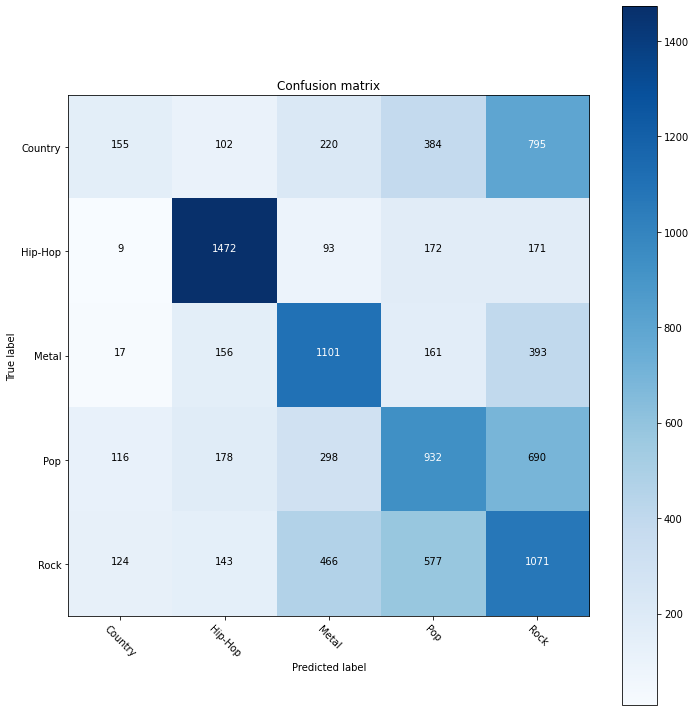

In [63]:
confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plot_confusion_matrix_net(cm=confusion_matrix,classes=labels_names)